# Quantum representations of classical data tutorial

## Table of contents
- Qubit Lattice
- FRQI
- MCRQI

Information is an abstract concept that refers to something which has the *potential* to inform. Images are a kind of classical data which convey visual information. Operating with information may allow us to obtain *more* information. 

Information can be represented in an infinite number of ways, some useful, some not. 

Images are often represented using the RGB model, where one has three independent matrices, one for each primary color. But there also exists the HSI model, which represents and image via the hue, saturation and intensity.

It is pretty obvious that both of this representations are better suited, more efficient, to *inform* about the contents of an image compared to a flattened representation, despite containing essentially the same information.

In the quantum realm the same thing happens. With the added complication that we work with a less intuitive paradigm. 

In this tutorial we'll focus on images

QC in 3 lines.


Qubits are fancy bits. Bits are like a switch, qubits are like a fancy switch which can be correlated in a way simple switches cannot. As with bits, we have logical gates for fancy bits, aka qubits.

Fancy switches are a bit picky so they are vulnerable to noise and change their behaviour once you look at them.

# Introduction to QC with Qiskit

* qiskit
* qiskit-ibm-runtime
* 'qiskit[visualization]'

In [3]:
import qiskit
import qiskit_aer

In [4]:
# Registers
n_qubits = 5
n_bits   = 5

qReg = qiskit.QuantumRegister(n_qubits, "qReg") 
cReg = qiskit.ClassicalRegister(n_bits, 'cReg')

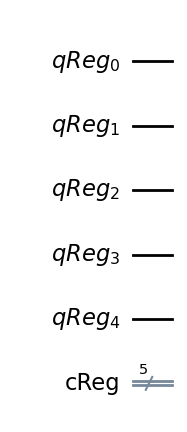

In [5]:
# Circuit
#   - a circuit is composed by registers
circuit = qiskit.QuantumCircuit(qReg, cReg)

circuit.draw(output='mpl')

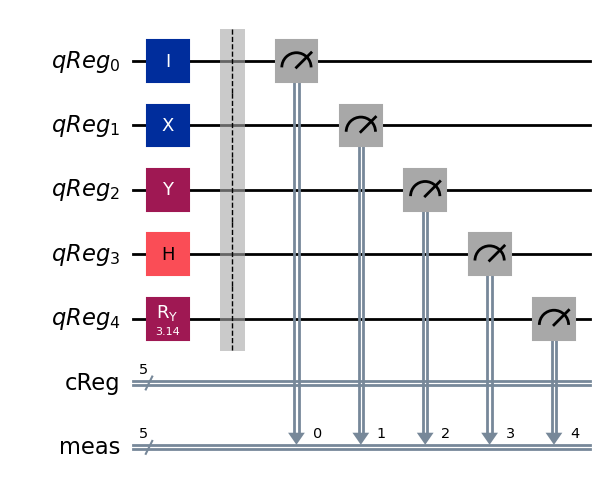

In [6]:
# Gates
#   - we can place gates in each register to do operations
circuit.id(0)
circuit.x(1)
circuit.y(2)
circuit.h(3)
circuit.ry(3.1415, 4)
circuit.measure_all()
circuit.draw(output='mpl')


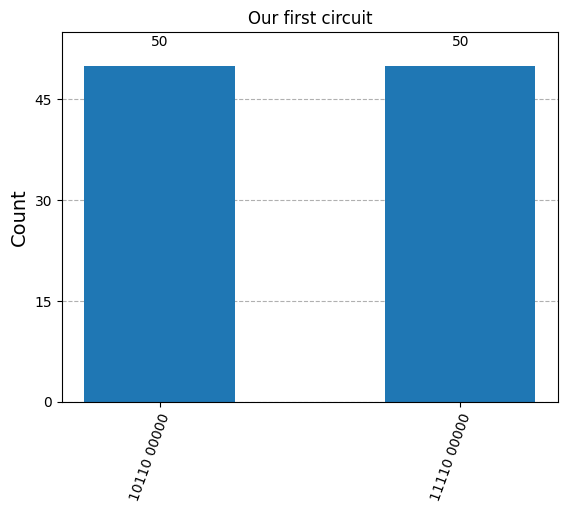

In [7]:
import qiskit.visualization


simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(circuit, simulator)

result = simulator.run(circuit, shots=100).result()
counts = result.get_counts(circuit)

qiskit.visualization.plot_histogram(counts, title="Our first circuit")

# Qubit lattice

The simplest way we can represent an image is via the *Qubit Lattice Representation*. As you will see this is a very non-efficient method but serves as a very good introduction point for quantum representations of images.

- We store the images as a lattice (matrix) of qubits.
- We store the color/intensity as $\theta$.    
  - interpolate the pixel value with an angle from 0 to $\pi$.
- We store three copies. (I think we can forget about this)

In [8]:
# 4 x 4 Image
import numpy as np
import matplotlib.pyplot as plt

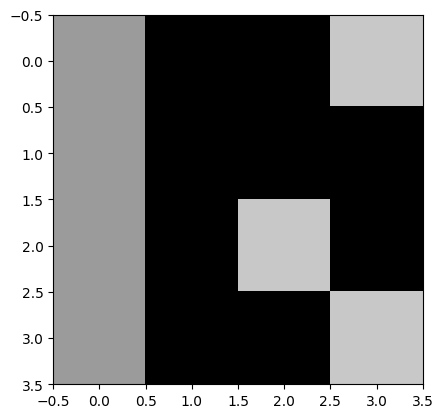

In [9]:
image = np.zeros((4,4), dtype=np.uint8)
image[0::1, 0] = 155  
image[2, 2] = 200
image[3, 3] = 200
image[0, 3] = 200

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

How do we translate this image? we convert it to a flat vector and convert the pixel intensities to angles between zero and pi. 

In [10]:
signal = image.flatten()
signal = np.interp(signal, (0, 255), (0, np.pi))
pixels = len(signal)

In [11]:
qPixels = qiskit.QuantumRegister(pixels, 'qPixel')
qClassic = qiskit.ClassicalRegister(pixels, 'classic')

qubit_lattice = qiskit.QuantumCircuit(qPixels, qClassic)

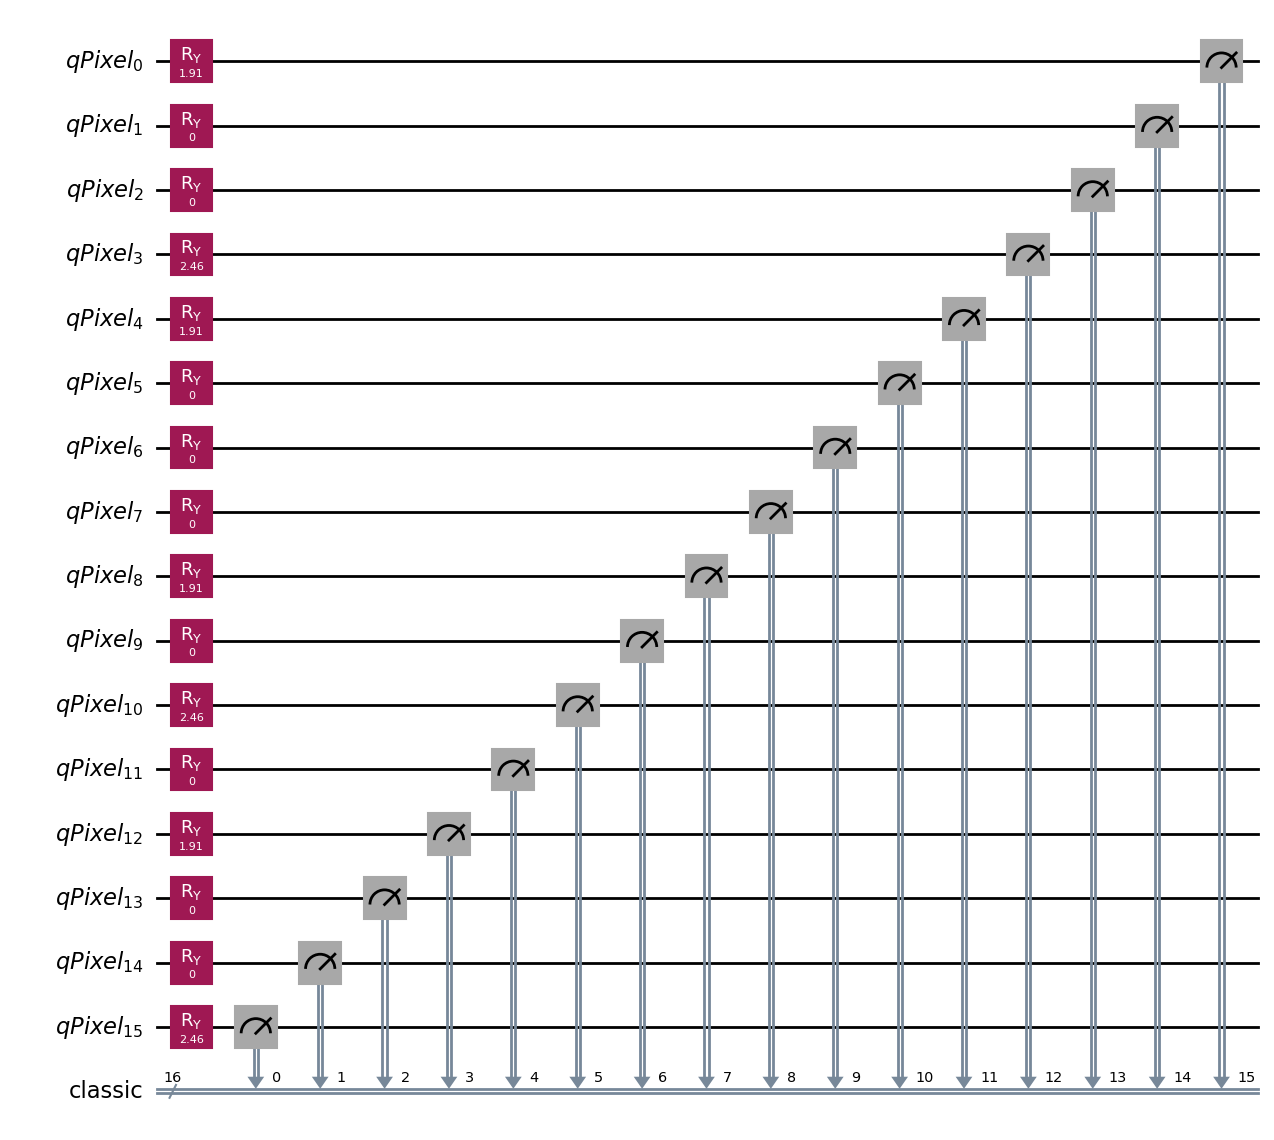

In [12]:
for idx, angle in enumerate(signal):
    qubit_lattice.ry(angle, idx)

qbits_to_measure = list(reversed(range(pixels)))
cbits_to_measure = range(pixels)
qubit_lattice.measure(qbits_to_measure, cbits_to_measure) 
qubit_lattice.draw('mpl')

In [13]:
print(qubit_lattice.depth())
print(qubit_lattice.num_qubits)

2
16


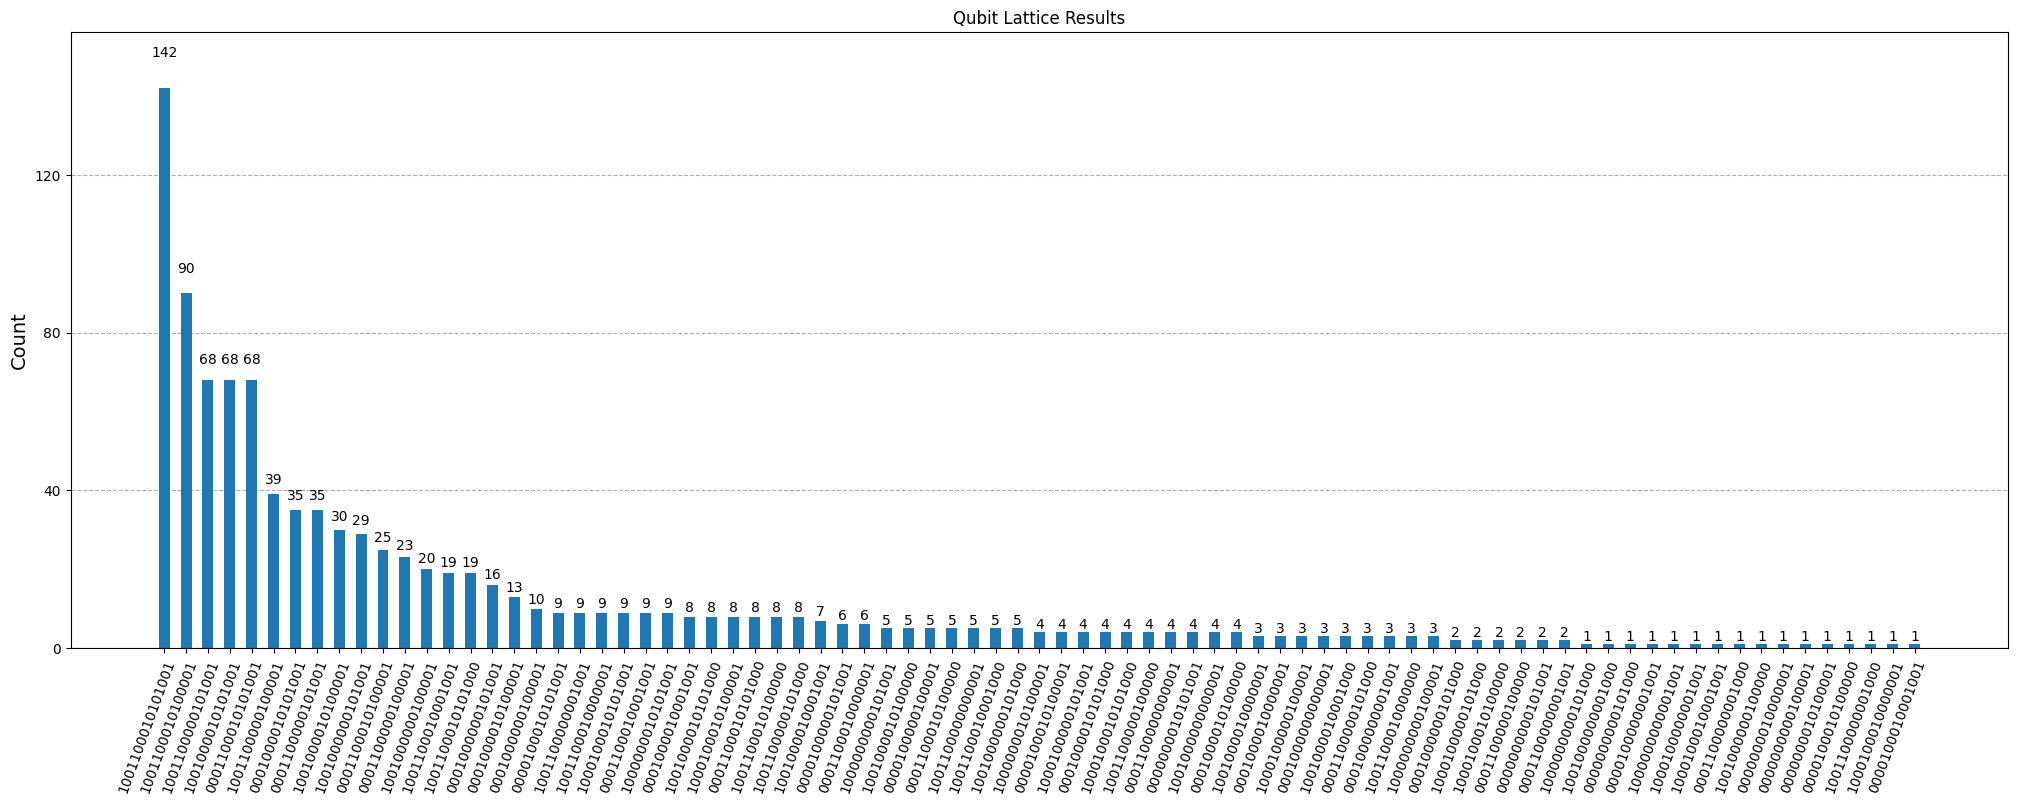

In [14]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(qubit_lattice, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(25, 8), sort="value_desc", title="Qubit Lattice Results")

In [15]:
values = np.zeros((len(signal)))
for item in counts:
    for i, bit in enumerate(item):
        if bit=='0':
            values[i]+=counts[item]

values = values/shots
print(values)

[0.329 1.    1.    0.095 0.318 1.    1.    1.    0.334 1.    0.115 1.
 0.353 1.    1.    0.111]


In [16]:

reconstruct = []
for pixel in values:
    color = 2*np.arccos((pixel)**(1/2)) # "shots" corresponds to the total counts value.
    reconstruct.append(color)

In [17]:
reconstruct = list(np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int))
reconstruct = np.reshape(reconstruct, (4,4))

In [18]:
print(reconstruct)
print('---------------------')
print(image)

[[155   0   0 204]
 [157   0   0   0]
 [154   0 198   0]
 [151   0   0 199]]
---------------------
[[155   0   0 200]
 [155   0   0   0]
 [155   0 200   0]
 [155   0   0 200]]


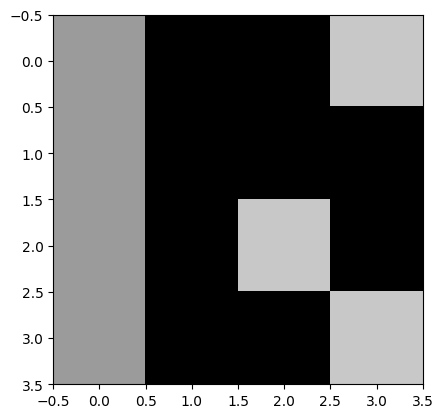

In [19]:
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

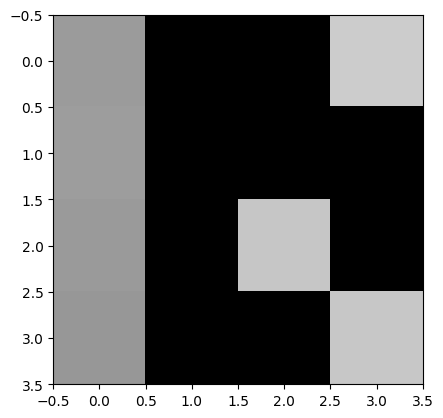

In [20]:
plt.imshow(reconstruct, cmap='gray', vmin=0, vmax=255)
plt.title('')
plt.show()

# FRQI

FRQI is the first *efficient* quantum representation of single-channel images which exploits the *quantumness* of quantum computers.

In [21]:
import matplotlib.pyplot as plt
import math

We require $2n +1$ for representing a $2^n \times 2^n$ image.

In [22]:
flat_image = image.flatten()
flat_image

array([155,   0,   0, 200, 155,   0,   0,   0, 155,   0, 200,   0, 155,
         0,   0, 200], dtype=uint8)

In [23]:
angle_rep = np.interp(flat_image, (0, 255), (0, np.pi/2))

required_qubits = int(np.ceil(math.log(len(flat_image), 2)))
print(required_qubits)

4


$$|\text{FRQI}\rangle=\mathcal R \left(\mathcal H \left(|0\rangle^{\otimes 2n+1}\right)\right) $$


In [24]:
qRegCord = qiskit.QuantumRegister(required_qubits, 'coordinates')
qRegColor = qiskit.QuantumRegister(1, 'color')
cReg = qiskit.ClassicalRegister(qRegCord.size+qRegColor.size, 'bits')

frqi_circ = qiskit.QuantumCircuit(qRegColor, qRegCord, cReg)
n_qubits = frqi_circ.num_qubits

$$\text{FRQI}=\mathcal H \left(|0\rangle^{\otimes 2n+1}\right) \cdots $$

This gives us an equal weighted superposition of all states. We have the indices of all pixels, with an equal weight. We have a colorless image flat image (all gray)

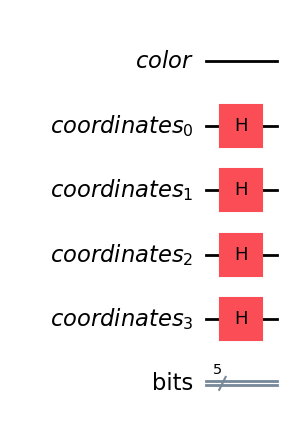

In [25]:
frqi_circ.h(qRegCord)
frqi_circ.draw('mpl')

In [26]:
controls = []
for i, _ in enumerate(qRegCord):
    controls.extend([qRegCord[i]]) # Store the no-target qubits (also named controls)
    
print(controls)
print(qRegColor)
print(qRegCord)
print(np.array(qRegCord))
print(np.array(qRegColor))

[Qubit(QuantumRegister(4, 'coordinates'), 0), Qubit(QuantumRegister(4, 'coordinates'), 1), Qubit(QuantumRegister(4, 'coordinates'), 2), Qubit(QuantumRegister(4, 'coordinates'), 3)]
QuantumRegister(1, 'color')
QuantumRegister(4, 'coordinates')
[Qubit(QuantumRegister(4, 'coordinates'), 0)
 Qubit(QuantumRegister(4, 'coordinates'), 1)
 Qubit(QuantumRegister(4, 'coordinates'), 2)
 Qubit(QuantumRegister(4, 'coordinates'), 3)]
[Qubit(QuantumRegister(1, 'color'), 0)]


In [27]:
for i, theta in enumerate(angle_rep):
    # Generate the different possible states of our qubits
    qubit_index_bin = "{0:b}".format(i).zfill(required_qubits)
   
    # TODO: UNDERSTAND NOT GATES FUNCTION
    # mmmm
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            print("[1] We apply the X-Gate to ", qRegCord[k])
            print("\t", "to index ", k, " of ", qubit_index_bin, " because it's one.")
            frqi_circ.x(qRegCord[k]) # Apply X-gate to qubits in state '1'
    frqi_circ.barrier()
    
    # Applies the Ry multi-controlled gate to all the circuit qubits
    frqi_circ.mcry(theta=2*theta,
                  q_controls=controls,
                  q_target=qRegColor[0])
    
    frqi_circ.barrier()
    
    # here we undo the last loop
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            #print("[2] We apply the X-Gate to ", qRegCord[k])
            #print("\t", "to index ", k, " of ", qubit_index_bin, " because it's one.")
            frqi_circ.x(qRegCord[k]) # Again, we apply X-gate to qubits in state '1'
     
    frqi_circ.barrier()


frqi_circ.measure(list(reversed(range(frqi_circ.num_qubits))), list(range(cReg.size)))

[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 3)
	 to index  3  of  0001  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 2)
	 to index  2  of  0010  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 2)
	 to index  2  of  0011  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 3)
	 to index  3  of  0011  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 1)
	 to index  1  of  0100  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 1)
	 to index  1  of  0101  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 3)
	 to index  3  of  0101  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 1)
	 to index  1  of  0110  because it's one.
[1] We apply the X-Gate to  Qubit(QuantumRegister(4, 'coordinates'), 2)
	 to ind

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [28]:
print(frqi_circ.depth())

160


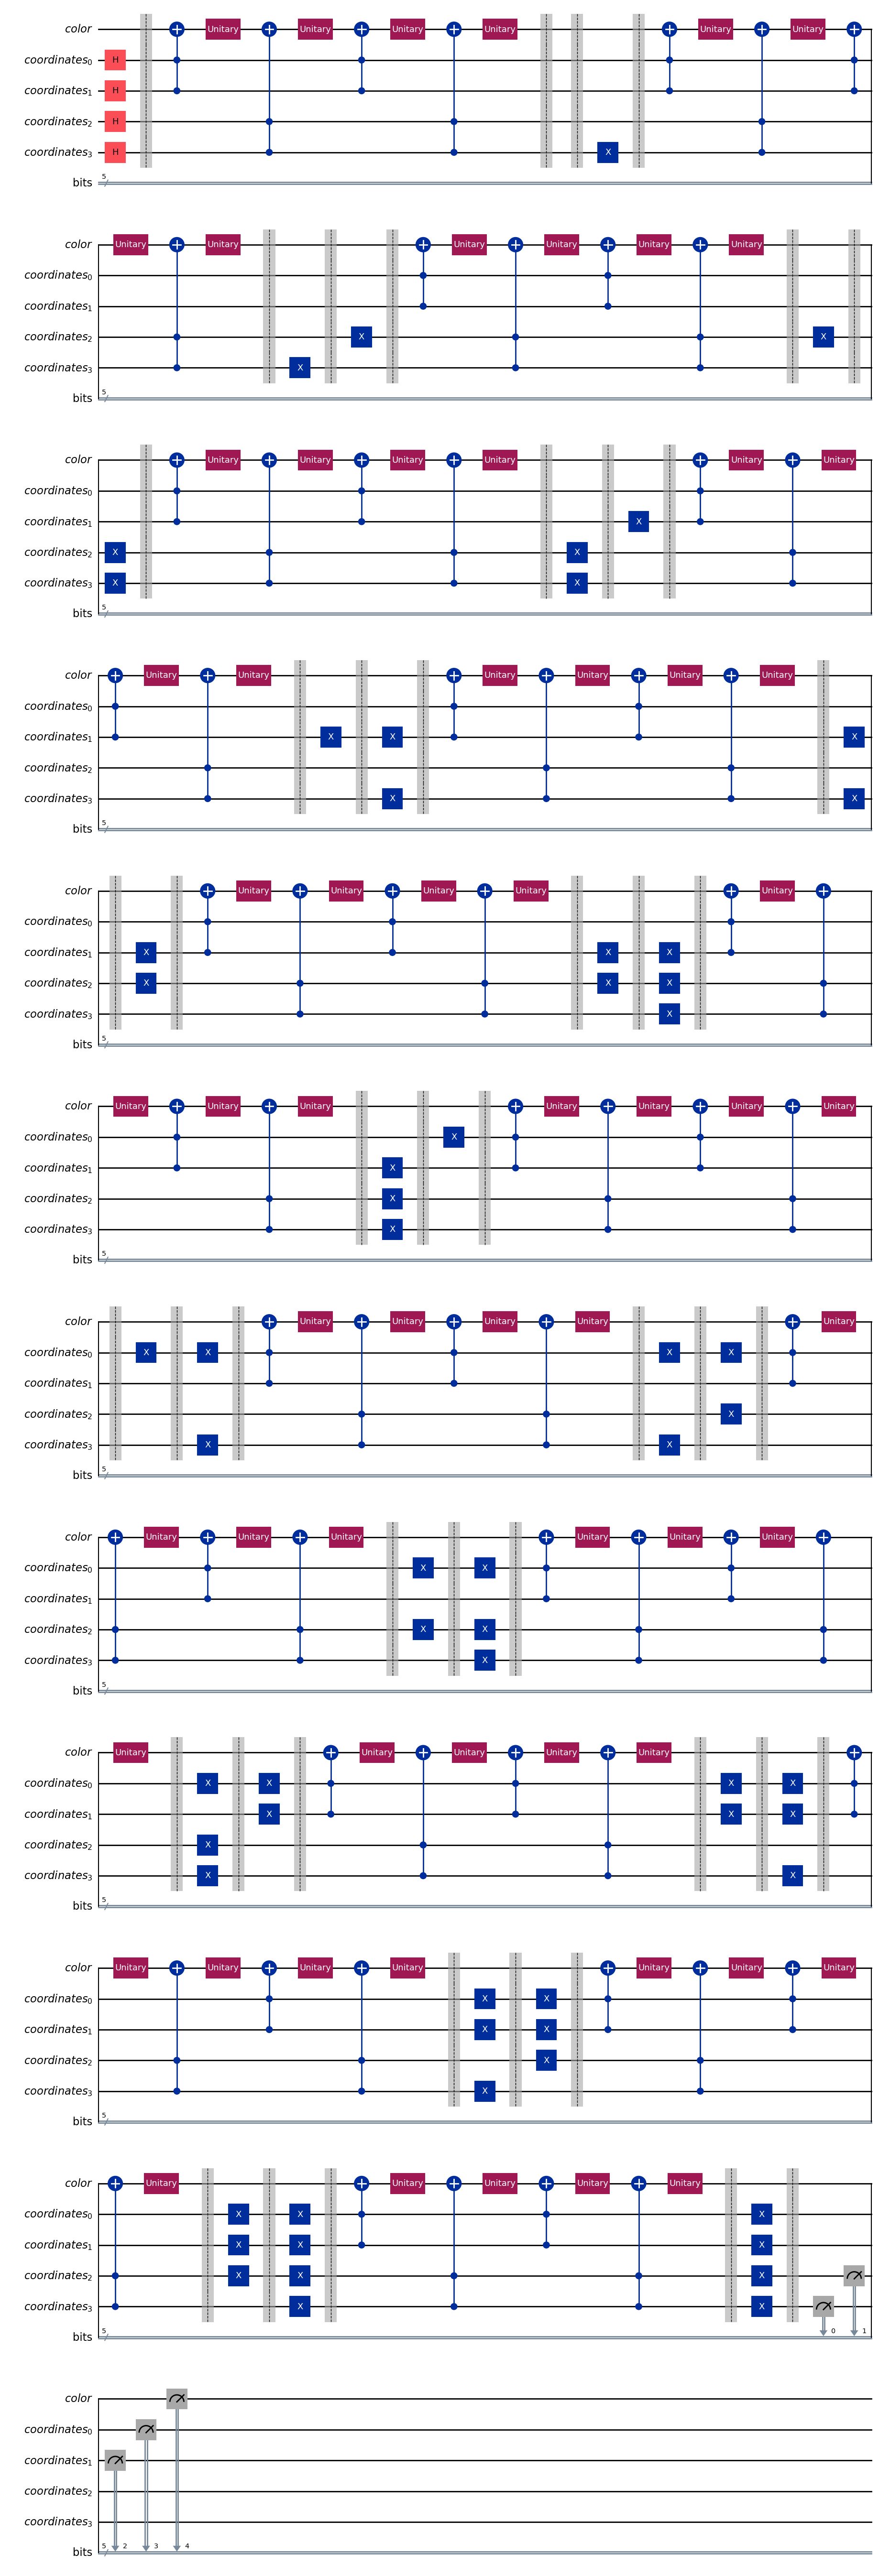

In [29]:
frqi_circ.draw('mpl')

**TODO: Add reconstruction etc.**
- what operations does this embedding facilitate?¿

# MCRQI

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


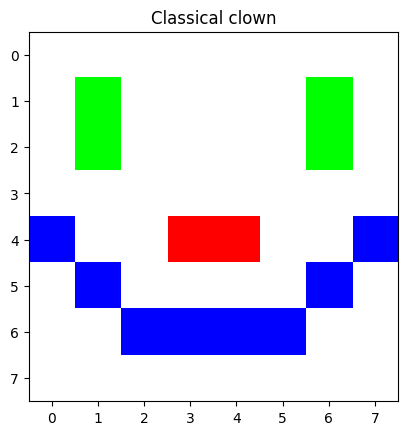

In [30]:
image = np.zeros((8,8,3))
image[:,:,0] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255, 255, 255, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,1] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255,   0,   0, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0,255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,2] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255,   0,   0, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

plt.imshow(image.reshape(8,8,3))
plt.title('Classical clown')
plt.show()

In [31]:
xqbits = math.log(image.shape[0],2)
yqbits = math.log(image.shape[1],2)
coord_qbits = int(xqbits) + int(yqbits)
print(coord_qbits)

6


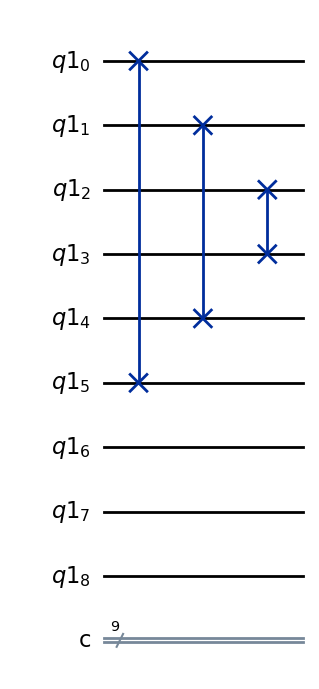

In [32]:
qr = qiskit.QuantumRegister(coord_qbits + 3)
cr = qiskit.ClassicalRegister(coord_qbits + 3, 'c')
qc = qiskit.QuantumCircuit(qr, cr)

for k in range(int(np.floor(coord_qbits/2))):
    qc.swap(k,coord_qbits - 1 - k)
qc.draw('mpl')

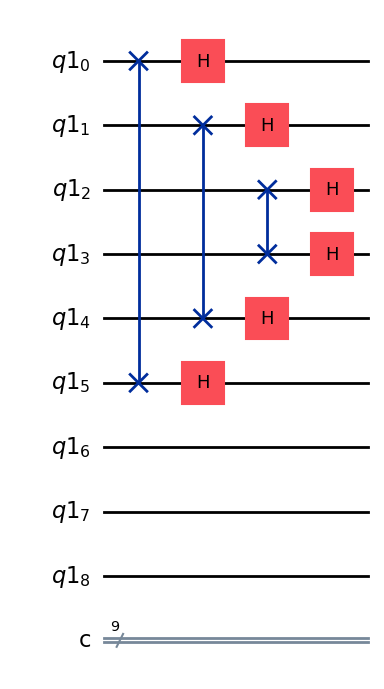

In [33]:
for i in range(coord_qbits):
    qc.h(i)
qc.draw('mpl')

In [34]:
from qiskit.circuit.library.standard_gates.ry import RYGate

for layer_num, input_im in enumerate(image.T): # loop for iterating R,G,B channels
    input_im = input_im.flatten() # flatten the image to 1-D
    input_im = np.interp(input_im, (0, 255), (0, np.pi/2)) # convert the color value into angles

    for i, pixel in enumerate(input_im):
        arr = list(range(coord_qbits)) # control qubits
        arr.append(int(coord_qbits + layer_num)) # target qubit application
        cMry = RYGate(2*pixel).control(coord_qbits) # create MCRY 

        to_not = "{0:b}".format(i).zfill(coord_qbits) # each possible state
        for j, bit in enumerate(to_not):
            if int(bit): # if bit == 1
                qc.x(j)
        qc.barrier()
        qc.append(cMry, arr) # apply MCRY

        if i!=len(input_im)-1 or layer_num!=2:
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            
for k in range(int(np.floor(coord_qbits/2))):
    qc.swap(k, coord_qbits - 1 - k)
    qc.barrier()

qc.swap(-1, -3)
qc.barrier()

for i in range(coord_qbits + 3):
    qc.measure(i, i)
    
print(qc.depth())
print(qc.num_qubits)

576
9


# SQR

# Real Ket

# QSMC-QSNC

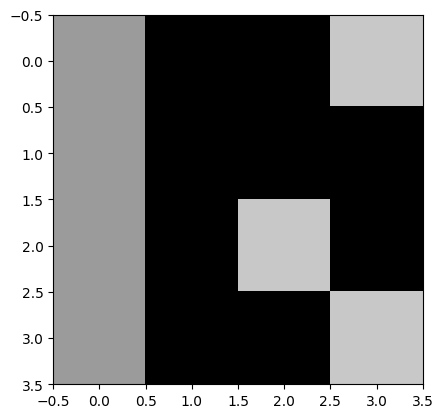

In [35]:
image = np.zeros((4,4), dtype=np.uint8)
image[0::1, 0] = 155  
image[2, 2] = 200
image[3, 3] = 200
image[0, 3] = 200

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

In [36]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
print(w_bits, h_bits)

2 2


In [37]:
im_list = image.flatten()
thetas = np.interp(im_list, (0, 255), (0, np.pi/2))
print(thetas)
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))
print(phis)

[0.95479777 0.         0.         1.23199712 0.95479777 0.
 0.         0.         0.95479777 0.         1.23199712 0.
 0.95479777 0.         0.         1.23199712]
[0.         0.09817477 0.19634954 0.29452431 0.39269908 0.49087385
 0.58904862 0.68722339 0.78539816 0.88357293 0.9817477  1.07992247
 1.17809725 1.27627202 1.37444679 1.47262156]


In [38]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
print(num_ind_bits)

4


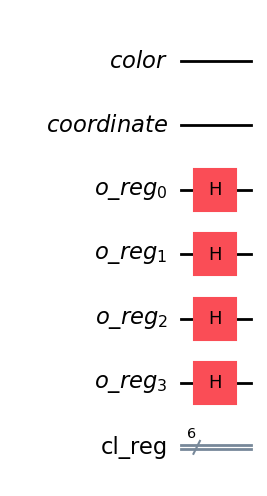

In [39]:
O = qiskit.QuantumRegister(num_ind_bits, 'o_reg')
color = qiskit.QuantumRegister(1,'color')
coordinate = qiskit.QuantumRegister(1, 'coordinate')
cr = qiskit.ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc = qiskit.QuantumCircuit(color, coordinate, O, cr)
# qc.i(color)
# qc.i(coordinate)
qc.h(O)
qc.draw('mpl')

In [40]:
controls = []
for i, _ in enumerate(O):
    controls.extend([O[i]])
print(controls)

[Qubit(QuantumRegister(4, 'o_reg'), 0), Qubit(QuantumRegister(4, 'o_reg'), 1), Qubit(QuantumRegister(4, 'o_reg'), 2), Qubit(QuantumRegister(4, 'o_reg'), 3)]


In [41]:
for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k])
            
    qc.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns: # if intensity -> value == 0
            print(i, 'color')
            print(theta)
            qc.mcry(theta=2*theta,
                          q_controls=controls,
                          q_target=color[0]) # mcry application to color target
        else: # if coordinate -> value == 1
            print(i, 'coord')
            print(phi)
            qc.mcry(theta=2*phi,
                          q_controls=controls,
                          q_target=coordinate[0]) # mcry application to coordinate target
       
    qc.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(O[k])
                
    qc.barrier()

0 color
0.9547977672674861
0 coord
0.0
1 color
0.0
1 coord
0.09817477042468103
2 color
0.0
2 coord
0.19634954084936207
3 color
1.231997119054821
3 coord
0.2945243112740431
4 color
0.9547977672674861
4 coord
0.39269908169872414
5 color
0.0
5 coord
0.4908738521234052
6 color
0.0
6 coord
0.5890486225480862
7 color
0.0
7 coord
0.6872233929727672
8 color
0.9547977672674861
8 coord
0.7853981633974483
9 color
0.0
9 coord
0.8835729338221293
10 color
1.231997119054821
10 coord
0.9817477042468103
11 color
0.0
11 coord
1.0799224746714913
12 color
0.9547977672674861
12 coord
1.1780972450961724
13 color
0.0
13 coord
1.2762720155208536
14 color
0.0
14 coord
1.3744467859455345
15 color
1.231997119054821
15 coord
1.4726215563702154


In [42]:
qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

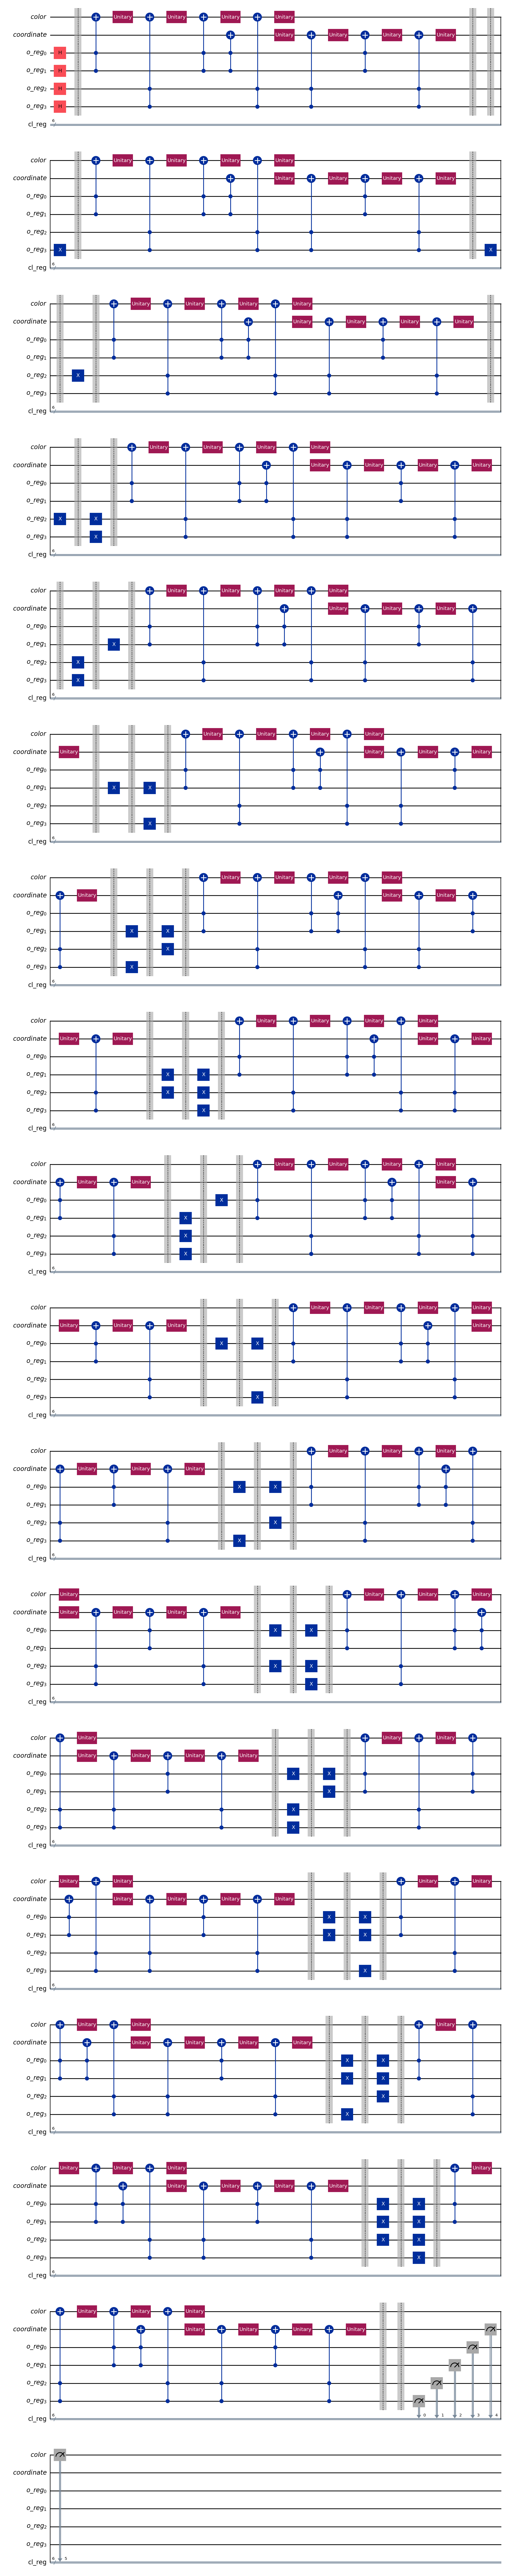

In [43]:
qc.draw('mpl')

# OQIM

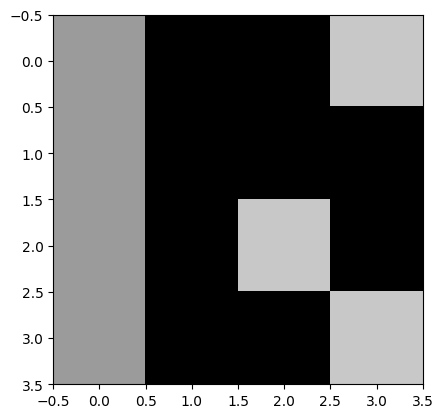

In [44]:
image = np.zeros((4,4), dtype=np.uint8)
image[0::1, 0] = 155  
image[2, 2] = 200
image[3, 3] = 200
image[0, 3] = 200

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

# NAQSS

# NEQR

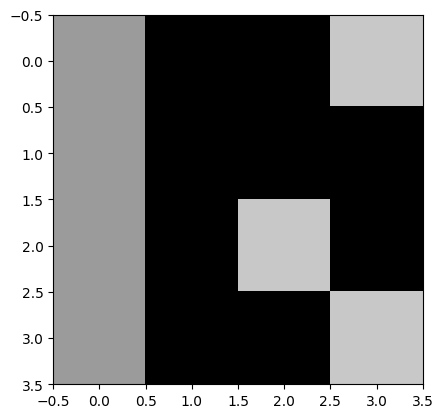

In [45]:
image = np.zeros((4,4), dtype=np.uint8)
image[0::1, 0] = 155  
image[2, 2] = 200
image[3, 3] = 200
image[0, 3] = 200

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

In [46]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
print(w_bits, h_bits)

2 2


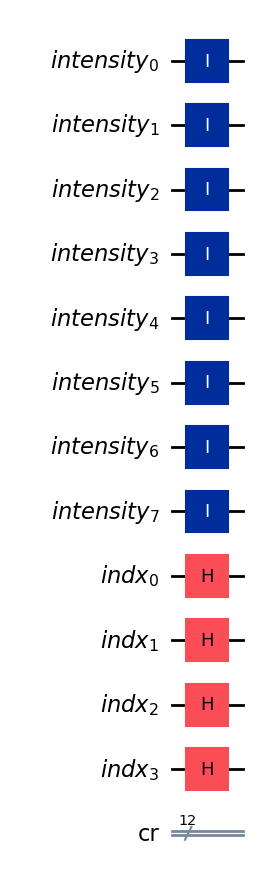

In [47]:
indx = qiskit.QuantumRegister(w_bits+h_bits, 'indx')
intensity = qiskit.QuantumRegister(8,'intensity')
cr = qiskit.ClassicalRegister(len(indx)+len(intensity), 'cr')
qc = qiskit.QuantumCircuit(intensity, indx, cr)
num_qubits = qc.num_qubits
input_im = image.copy().flatten()
qc.id(intensity)
qc.h(indx)
qc.draw('mpl')

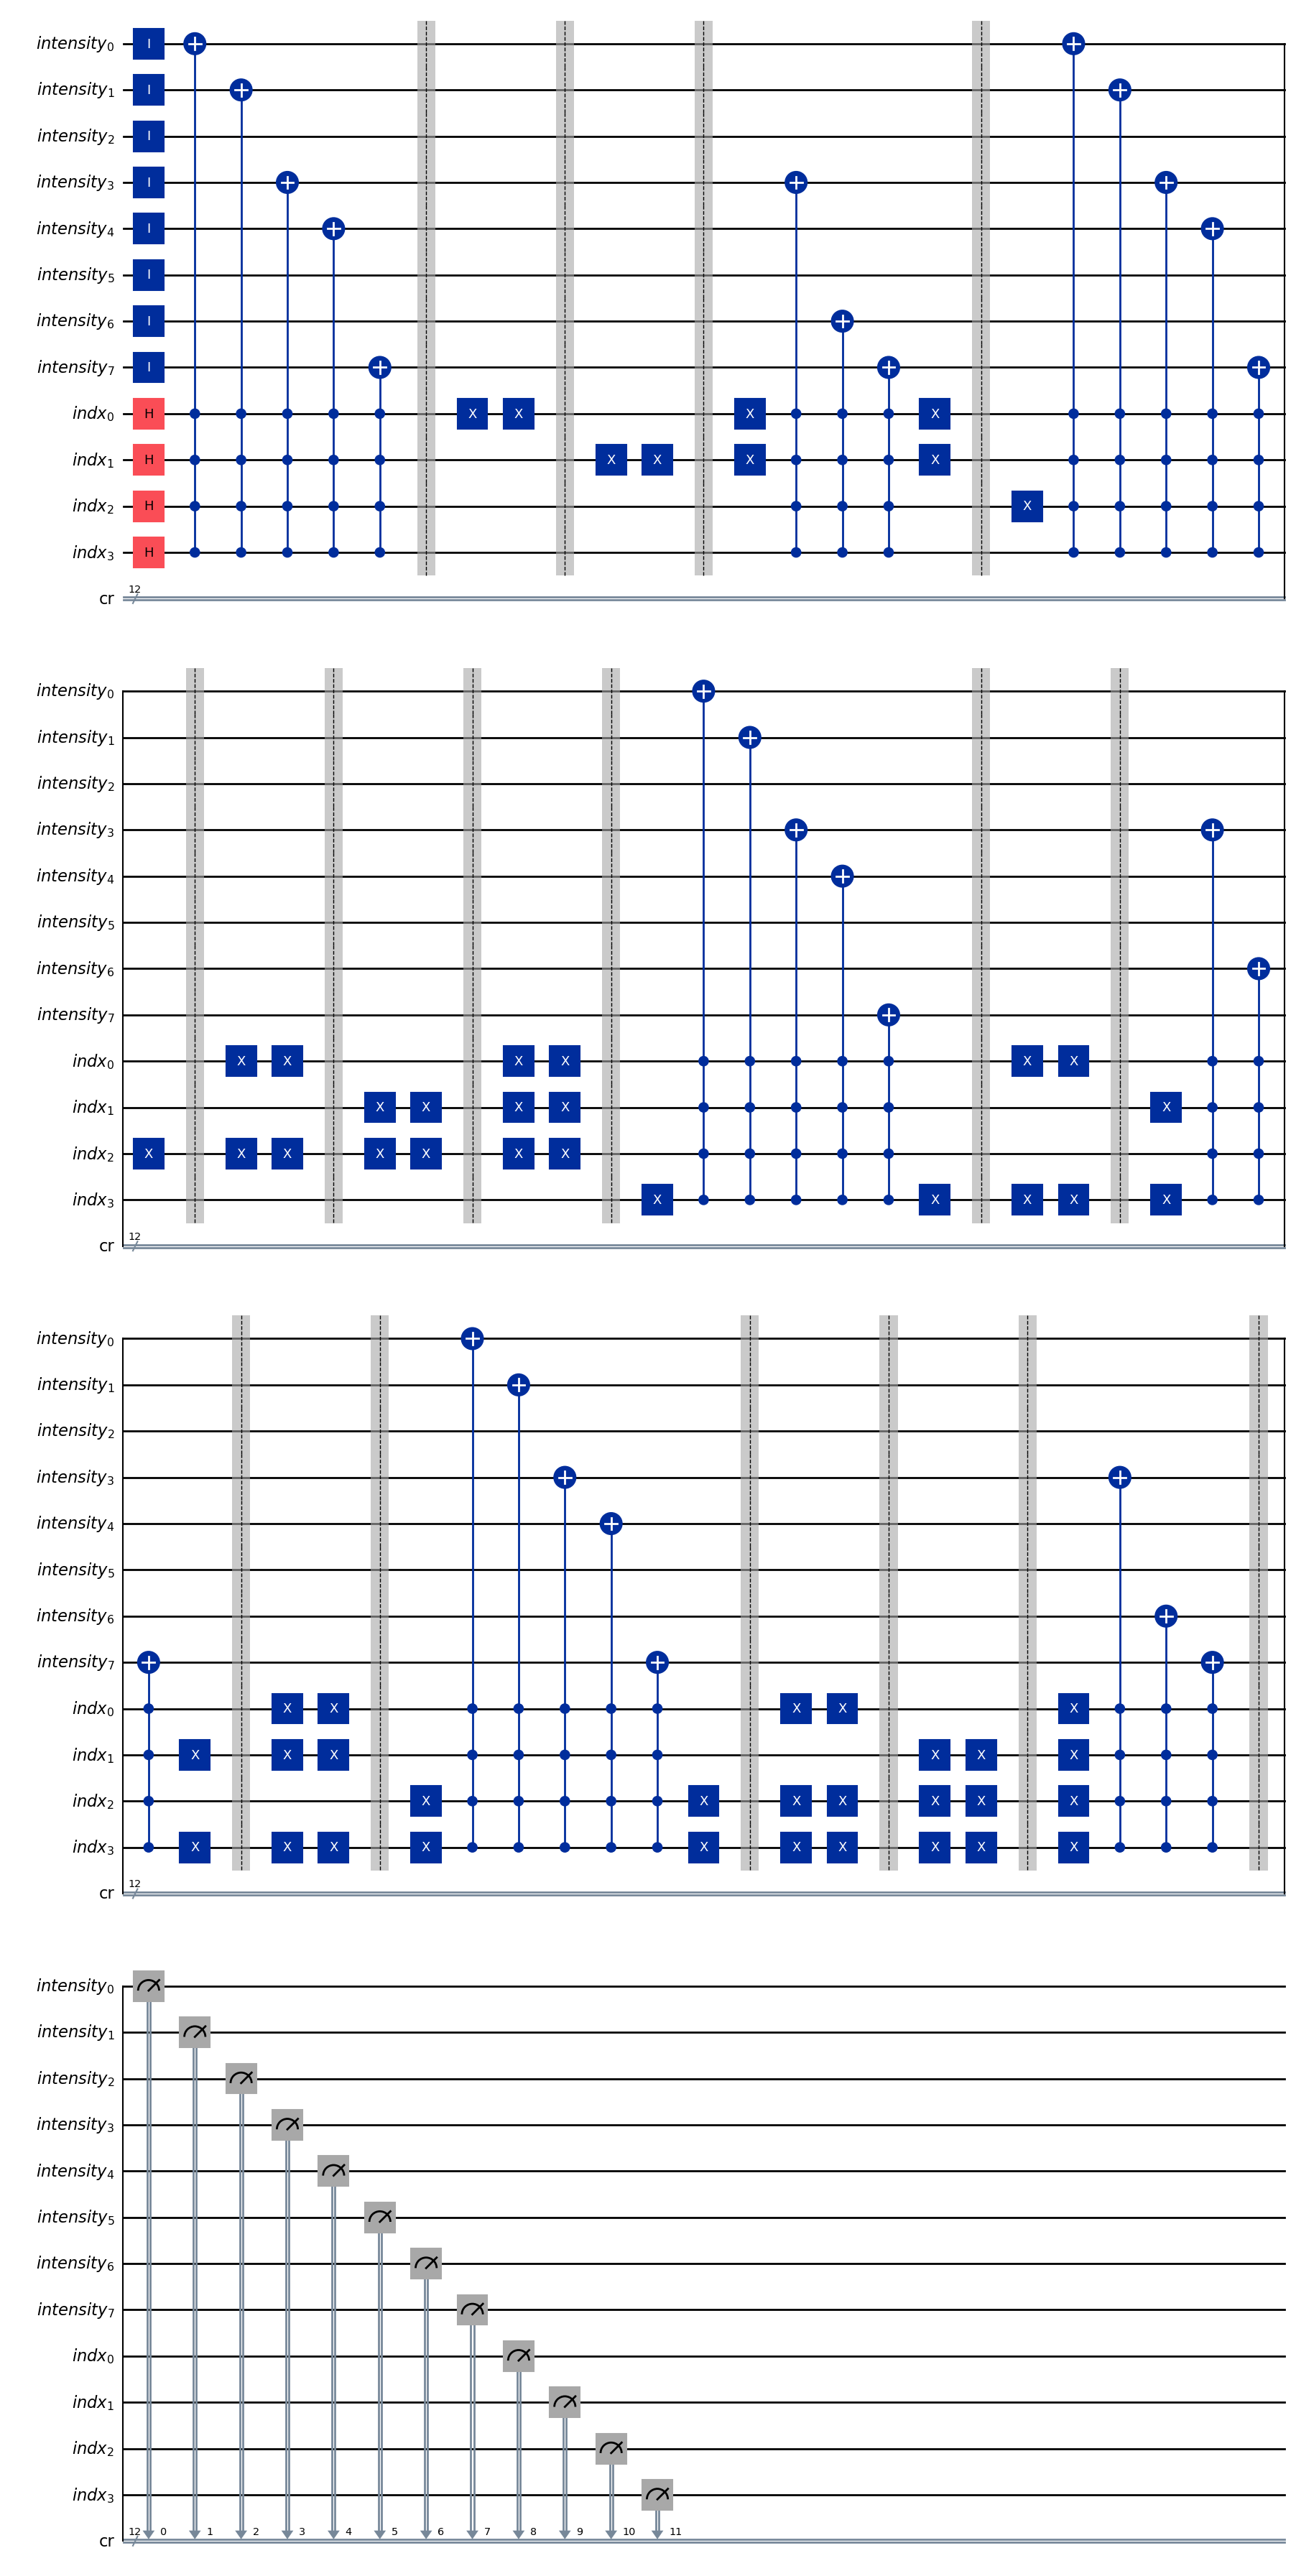

In [48]:
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord): # valor es igual a 1
            qc.x(qc.num_qubits-j-1) # se aplica rotación en la posición correspondiente en los qubit index (se resta j pero nunca llega a menos de 8)
    for idx, px_value in enumerate(pixel_bin[::-1]): #recorre el valor codificado en binario invertido
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc.x(qc.num_qubits-j-1)
    qc.barrier()
qc.measure(range(qc.num_qubits),range(cr.size))

qc.draw('mpl')

# BRQI

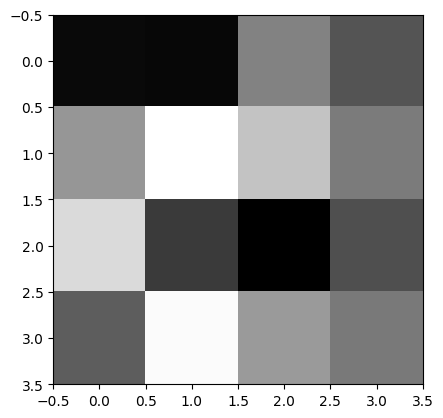

In [53]:
image = np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
plt.imshow(image, cmap = 'gray')

In [54]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
color_n_b = 8
color_n_b = int(np.ceil(math.log(color_n_b,2)))
print(w_bits, h_bits, color_n_b)

2 2 3


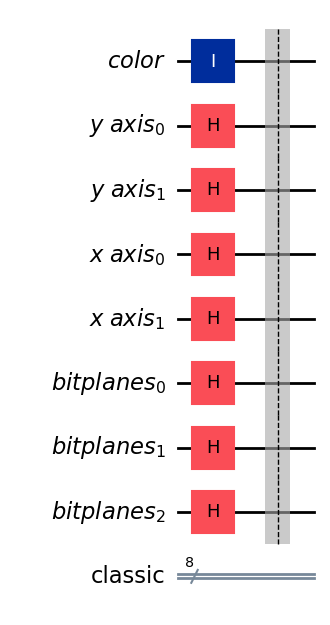

In [55]:
color = qiskit.QuantumRegister(1, 'color')
y_ax = qiskit.QuantumRegister(w_bits, 'y axis')
x_ax = qiskit.QuantumRegister(h_bits, 'x axis')
bitplane_q = qiskit.QuantumRegister(color_n_b, 'bitplanes')
classic = qiskit.ClassicalRegister(1+w_bits+h_bits+color_n_b, 'classic')
qc = qiskit.QuantumCircuit(color, y_ax, x_ax, bitplane_q, classic)

qc.id(color)
qc.h(x_ax)
qc.h(y_ax)
qc.h(bitplane_q)

qc.barrier()
qc.draw('mpl')

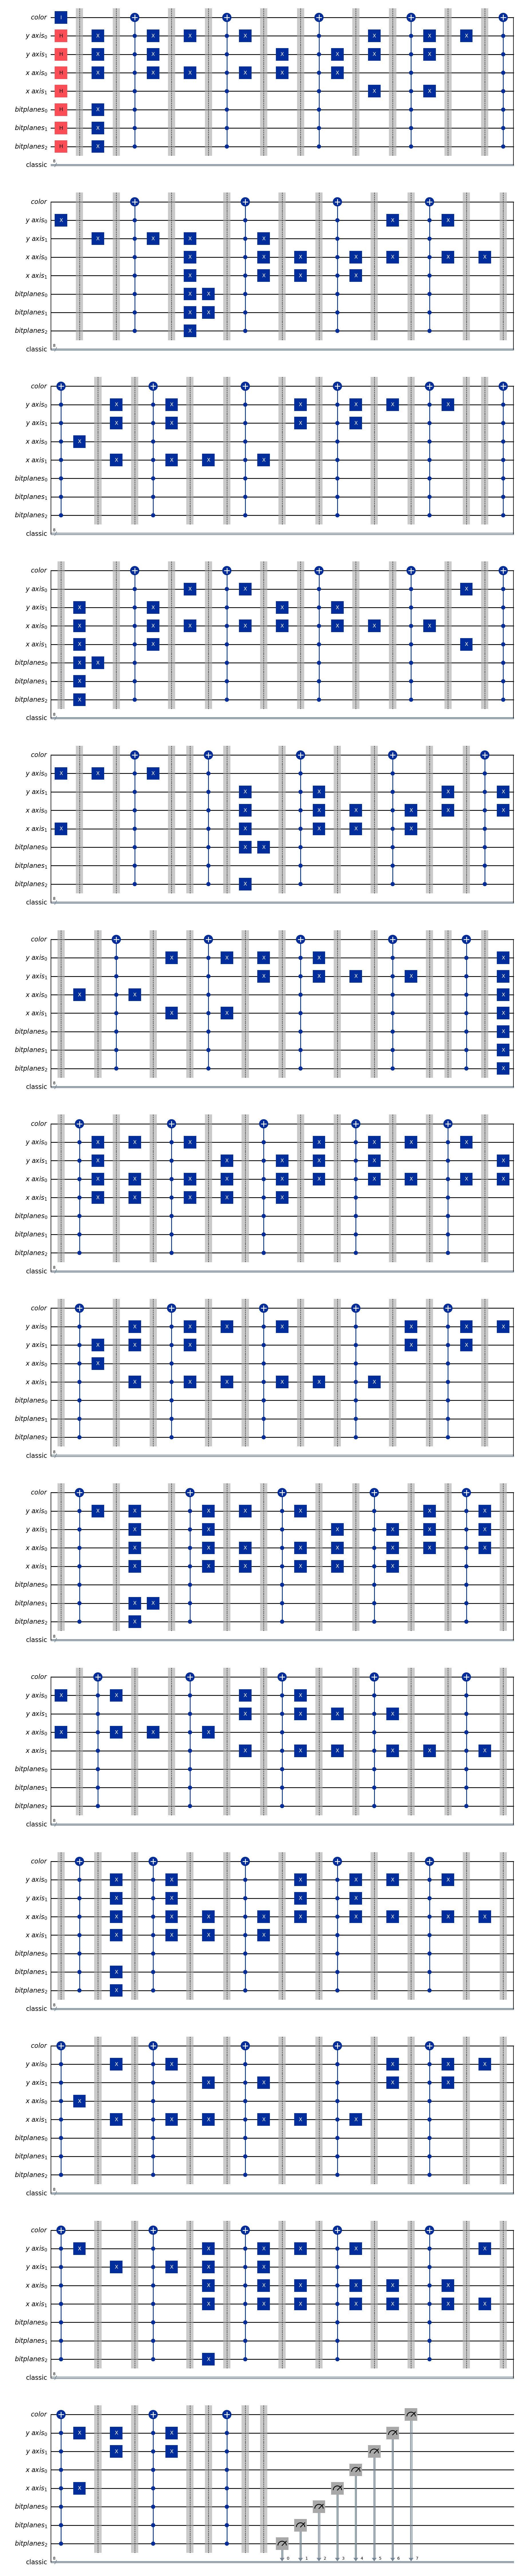

In [56]:
for bitplane in range(8):
    bit_bitplane = "{0:b}".format(bitplane).zfill(color_n_b)
    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = "{0:b}".format(int(image[i,j])).zfill(8)
            if pixel[bitplane]=='1':
                i_bit = "{0:b}".format(i).zfill(h_bits)
                for i_n, ibit in enumerate(i_bit):
                    if ibit!='1':
                        qc.x(x_ax[i_n])
                j_bit = "{0:b}".format(j).zfill(w_bits)
                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])
                qc.barrier()
                controls = list(range(color.size, qc.num_qubits))
                qc.mcx(controls, color)
                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])

                for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            qc.x(x_ax[i_n])
                qc.barrier()

    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
qc.barrier()
qc.measure(list(reversed(range(qc.num_qubits))), list(range(classic.size)))
qc.draw('mpl')

# GQRI

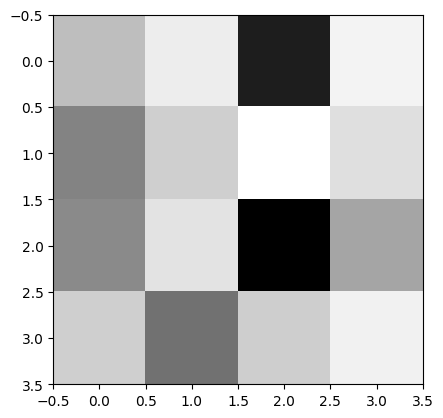

In [49]:
image = np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
plt.imshow(image, cmap = 'gray')

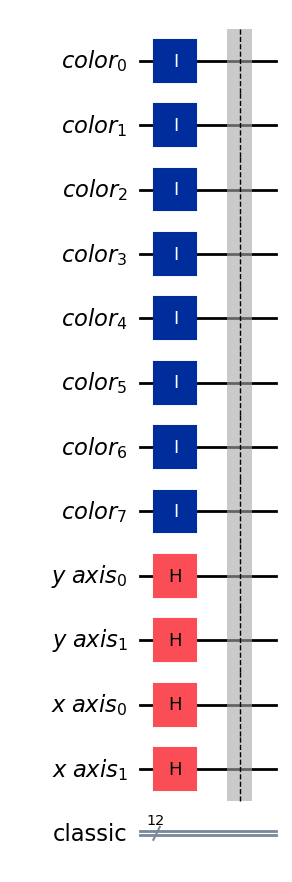

In [50]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = qiskit.QuantumRegister(q, 'color')
y_ax = qiskit.QuantumRegister(y, 'y axis')
x_ax = qiskit.QuantumRegister(x, 'x axis')
classic = qiskit.ClassicalRegister(x+y+q, 'classic')
qc = qiskit.QuantumCircuit(color, y_ax, x_ax, classic)

qc.id(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
qc.draw('mpl')

In [51]:
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])

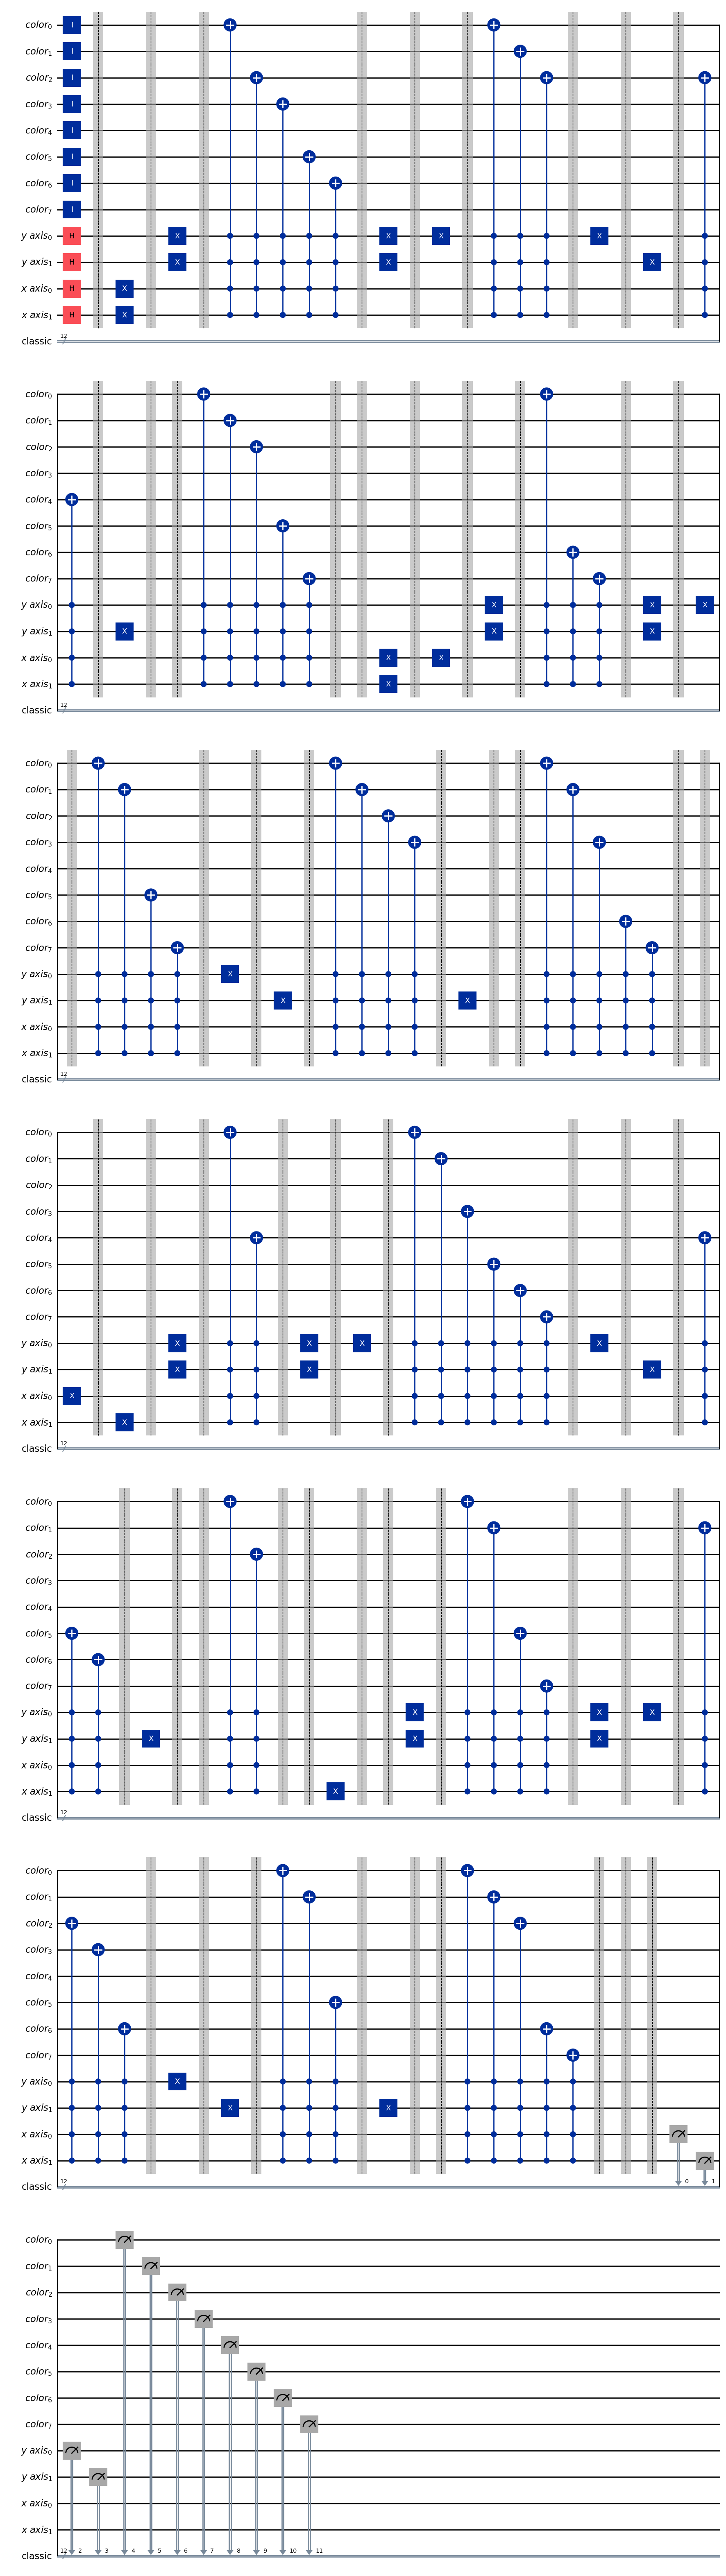

In [52]:
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = qiskit.circuit.library.XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

qc.draw('mpl')

# QUALPI

# GQIR

# QIIR

# QRMW